In [5]:
import pickle
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


train_data= pd.read_csv('/Users/xumoyan/Program/anaconda3/envs/cisc7201/final report/ML/dataset/train_data_encoded.csv')
test_data = pd.read_csv('/Users/xumoyan/Program/anaconda3/envs/cisc7201/final report/ML/dataset/test_data_encoded.csv')
X_train = train_data.drop(columns=['loan_status_flag'])
y_train = train_data['loan_status_flag']
X_test = test_data.drop(columns=['loan_status_flag'])
y_test = test_data['loan_status_flag']

feature_dict = pickle.load(open('/Users/xumoyan/Program/anaconda3/envs/cisc7201/final report/ML/selected_features.pkl', 'rb'))


    
# 打印每个特征子集
for subset_name, feature_subset in feature_dict.items():
    print(f"{subset_name} 特征子集:")
    print(feature_subset)
    print(f"特征数量: {len(feature_subset)}")
    print("-" * 50)



ANOVA 特征子集:
['initial_list_status', 'emp_title_cluster', 'emp_title_cluster_freq', 'pct_tl_nvr_dlq', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', 'emp_length', 'term', 'num_tl_op_past_12m', 'int_rate', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'sub_grade', 'inq_last_6mths', 'num_actv_bc_tl', 'percent_bc_gt_75', 'installment', 'acc_open_past_24mths', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'fico_range_low', 'fico_range_high', 'num_bc_sats', 'open_il_24m', 'open_il_12m', 'num_op_rev_tl', 'earliest_cr_line_year', 'earliest_cr_line_month', 'open_act_il', 'num_bc_tl', 'open_rv_24m', 'open_rv_12m', 'open_acc', 'num_sats', 'funded_amnt', 'loan_amnt', 'open_acc_6m', 'num_il_tl', 'mo_sin_rcnt_tl', 'inq_fi', 'pub_rec_bankruptcies', 'num_rev_accts']
特征数量: 48
--------------------------------------------------
MI 特征子集:
['sub_g


Processing feature subset: LightGBM (42 features)
[LightGBM] [Info] Number of positive: 135378, number of negative: 919246
[LightGBM] [Info] Number of positive: 135378, number of negative: 919246
[LightGBM] [Info] Number of positive: 135377, number of negative: 919247
[LightGBM] [Info] Number of positive: 135377, number of negative: 919247
[LightGBM] [Info] Number of positive: 135377, number of negative: 919247
[LightGBM] [Info] Number of positive: 135377, number of negative: 919247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6147
[LightGBM] [Info] Number of data points in the train set: 1054624, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-c

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

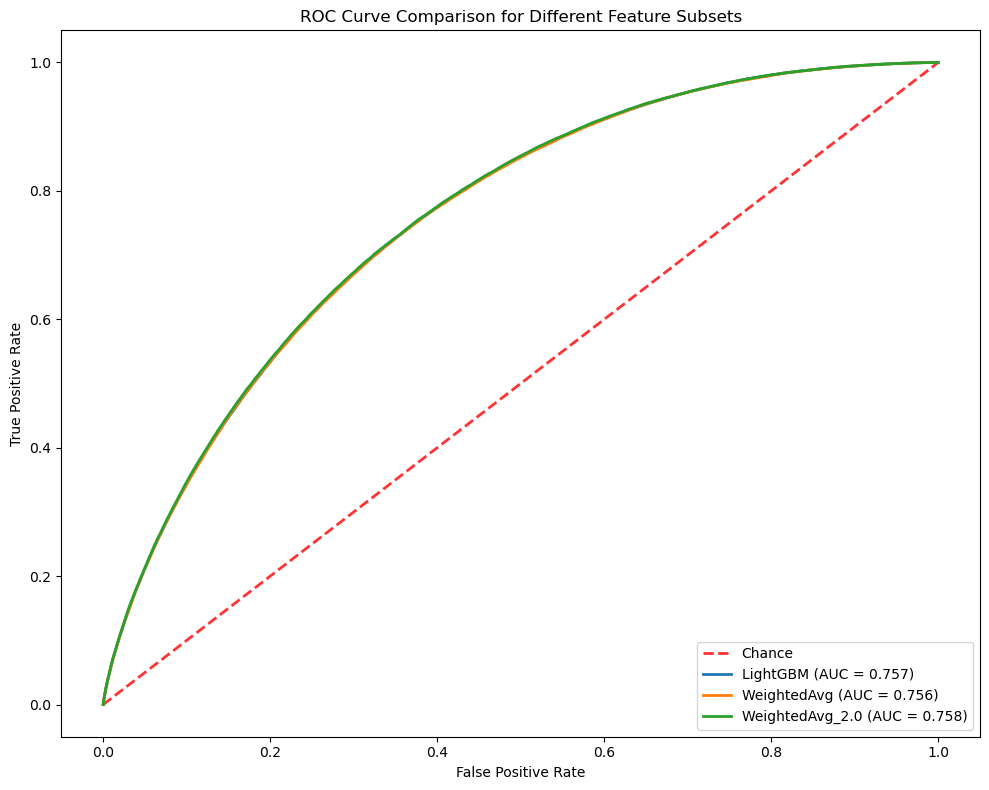

In [13]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# 自定义特征选择器
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.feature_names]

# 初始化结果存储
results = {}

# 创建分层KFold
stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 对每个特征子集进行模型训练和评估
for subset_name, feature_subset in feature_dict.items():
    print(f"\nProcessing feature subset: {subset_name} ({len(feature_subset)} features)")

    # 创建流水线
    pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_subset)),
        ('model', LGBMClassifier(class_weight='balanced', random_state=42))
    ])
    
    # 参数网格
    lgbm_params = {
        'model__n_estimators': [400, 500],
        'model__max_depth': [6],
        'model__learning_rate': [0.1]  # 可选的参数
    }
    
    # 网格搜索（使用roc_auc评分）
    gs = GridSearchCV(
        pipeline, 
        param_grid=lgbm_params,
        scoring='roc_auc',  # 使用ROC-AUC作为评分指标
        cv=stratified_cv,
        n_jobs=-1, 
        verbose=0
    )
    
    # 训练模型
    gs.fit(X_train, y_train)
    
    # 评估模型
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # 获取正类概率
    
    # 计算混淆矩阵各项指标
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)  # 真正率(Recall for Default class)
    fpr = fp / (fp + tn)  # 假正率
    
    # 计算ROC-AUC
    train_roc_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # 保存结果
    results[subset_name] = {
        'best_params': gs.best_params_,
        'train_roc_auc': train_roc_auc,
        'test_roc_auc': test_roc_auc,
        'train_accuracy': best_model.score(X_train, y_train),
        'test_accuracy': best_model.score(X_test, y_test),
        'report': classification_report(y_test, y_pred),
        'tpr': tpr,  # Default类召回率
        'fpr': fpr,  # 假正率
        'feature_count': len(feature_subset),
        'y_pred_proba': y_pred_proba  # 保存概率预测结果用于后续ROC曲线绘制
    }
    
    # 打印结果
    print(f"\n{subset_name} Subset Results:")
    print(f"Best Parameters: {gs.best_params_}")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Testing ROC-AUC: {test_roc_auc:.4f}")
    print(f"Recall for Default Class (TPR): {tpr:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print("\nClassification Report:\n", results[subset_name]['report'])
    
    # 绘制混淆矩阵（英文标题）
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-default', 'Default'])
    disp.plot(cmap='Blues')
    plt.title(f'{subset_name} Confusion Matrix')
    plt.tight_layout()
    plt.savefig(f'{subset_name}_confusion_matrix.png')
    plt.close()
    
    # 绘制ROC曲线（单个子集）
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{subset_name} Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(f'{subset_name}_roc_curve.png')
    plt.close()

# 输出所有特征子集的结果汇总（按ROC-AUC排序）
print("\nPerformance Summary of Feature Subsets:")
print("-" * 80)
print(f"{'Subset':<15} {'Features':<8} {'Train ROC-AUC':<12} {'Test ROC-AUC':<12} {'Recall(Default)':<14} {'FPR'}")
print("-" * 80)

for subset_name, result in sorted(results.items(), key=lambda x: x[1]['test_roc_auc'], reverse=True):
    depth = result['best_params']['model__max_depth']
    n_estimators = result['best_params']['model__n_estimators']
    print(f"{subset_name:<15} {result['feature_count']:<8} {depth:<10} {n_estimators:<10} "
          f"{result['test_roc_auc']:<12.4f} {result['tpr']:<14.4f} {result['fpr']:.4f}")
print("-" * 80)

# 可视化不同子集的性能对比（英文标题）
plt.figure(figsize=(16, 6))

# ROC-AUC分数对比
plt.subplot(1, 3, 1)
roc_data = pd.DataFrame({
    'Subset': list(results.keys()),
    'ROC-AUC': [results[k]['test_roc_auc'] for k in results],
    'Feature Count': [results[k]['feature_count'] for k in results]
})
roc_data = roc_data.sort_values('ROC-AUC', ascending=False)
sns.barplot(x='ROC-AUC', y='Subset', data=roc_data)
plt.title('ROC-AUC Score Comparison')

# 特征数量与性能关系
plt.subplot(1, 3, 2)
sns.scatterplot(x='Feature Count', y='ROC-AUC', hue='Subset', data=roc_data, s=100)
plt.title('Feature Count vs. ROC-AUC')

# 综合对比（ROC-AUC、TPR、FPR）
plt.subplot(1, 3, 3)
comparison_data = pd.DataFrame({
    'Subset': list(results.keys()),
    'ROC-AUC': [results[k]['test_roc_auc'] for k in results],
    'Recall(Default)': [results[k]['tpr'] for k in results],
    'FPR': [results[k]['fpr'] for k in results]
})
comparison_data = comparison_data.melt(id_vars='Subset', var_name='Metric', value_name='Score')
sns.barplot(x='Score', y='Subset', hue='Metric', data=comparison_data)
plt.title('Comprehensive Performance Comparison')
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('feature_subset_comparison_v2.png')
plt.close()

# 绘制所有子集的ROC曲线对比图
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

for subset_name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{subset_name} (AUC = {roc_auc:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Different Feature Subsets')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve_comparison.png')
plt.show()

In [1]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

feature_dict = pickle.load(open('/Users/xumoyan/Program/anaconda3/envs/cisc7201/final report/ML/selected_features_compare.pkl', 'rb'))
# 自定义特征选择器
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.feature_names]

# 初始化结果存储
results = {}

# 创建分层KFold
stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 对每个特征子集进行模型训练和评估
for subset_name, feature_subset in feature_dict.items():
    print(f"\nProcessing feature subset: {subset_name} ({len(feature_subset)} features)")

    # 创建流水线
    pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_subset)),
        ('model', LGBMClassifier(class_weight='balanced', random_state=42))
    ])
    
    # 参数网格
    lgbm_params = {
        'model__n_estimators': [400, 500],
        'model__max_depth': [6],
        'model__learning_rate': [0.1]  # 可选的参数
    }
    
    # 网格搜索（使用roc_auc评分）
    gs = GridSearchCV(
        pipeline, 
        param_grid=lgbm_params,
        scoring='roc_auc',  # 使用ROC-AUC作为评分指标
        cv=stratified_cv,
        n_jobs=-1, 
        verbose=1
    )
    
    # 训练模型
    gs.fit(X_train, y_train)
    
    # 评估模型
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # 获取正类概率
    
    # 计算混淆矩阵各项指标
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)  # 真正率(Recall for Default class)
    fpr = fp / (fp + tn)  # 假正率
    
    # 计算ROC-AUC
    train_roc_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # 保存结果
    results[subset_name] = {
        'best_params': gs.best_params_,
        'train_roc_auc': train_roc_auc,
        'test_roc_auc': test_roc_auc,
        'train_accuracy': best_model.score(X_train, y_train),
        'test_accuracy': best_model.score(X_test, y_test),
        'report': classification_report(y_test, y_pred),
        'tpr': tpr,  # Default类召回率
        'fpr': fpr,  # 假正率
        'feature_count': len(feature_subset),
        'y_pred_proba': y_pred_proba  # 保存概率预测结果用于后续ROC曲线绘制
    }
    
    # 打印结果
    print(f"\n{subset_name} Subset Results:")
    print(f"Best Parameters: {gs.best_params_}")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Testing ROC-AUC: {test_roc_auc:.4f}")
    print(f"Recall for Default Class (TPR): {tpr:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print("\nClassification Report:\n", results[subset_name]['report'])
    
    # 绘制混淆矩阵（英文标题）
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-default', 'Default'])
    disp.plot(cmap='Blues')
    plt.title(f'{subset_name} Confusion Matrix')
    plt.tight_layout()
    plt.savefig(f'{subset_name}_confusion_matrix.png')
    plt.close()
    
    # 绘制ROC曲线（单个子集）
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{subset_name} Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(f'{subset_name}_roc_curve.png')
    plt.close()

# 输出所有特征子集的结果汇总（按ROC-AUC排序）
print("\nPerformance Summary of Feature Subsets:")
print("-" * 80)
print(f"{'Subset':<15} {'Features':<8} {'Max Depth':<10} {'Trees':<10} {'Test ROC-AUC':<12} {'Recall(Default)':<14} {'FPR'}")
print("-" * 80)

for subset_name, result in sorted(results.items(), key=lambda x: x[1]['test_roc_auc'], reverse=True):
    depth = result['best_params']['model__max_depth']
    n_estimators = result['best_params']['model__n_estimators']
    print(f"{subset_name:<15} {result['feature_count']:<8} {depth:<10} {n_estimators:<10} "
          f"{result['test_roc_auc']:<12.4f} {result['tpr']:<14.4f} {result['fpr']:.4f}")
print("-" * 80)

# 可视化不同子集的性能对比（英文标题）
plt.figure(figsize=(16, 6))

# ROC-AUC分数对比
plt.subplot(1, 3, 1)
roc_data = pd.DataFrame({
    'Subset': list(results.keys()),
    'ROC-AUC': [results[k]['test_roc_auc'] for k in results],
    'Feature Count': [results[k]['feature_count'] for k in results]
})
roc_data = roc_data.sort_values('ROC-AUC', ascending=False)
sns.barplot(x='ROC-AUC', y='Subset', data=roc_data)
plt.title('ROC-AUC Score Comparison')

# 特征数量与性能关系
plt.subplot(1, 3, 2)
sns.scatterplot(x='Feature Count', y='ROC-AUC', hue='Subset', data=roc_data, s=100)
plt.title('Feature Count vs. ROC-AUC')

# 综合对比（ROC-AUC、TPR、FPR）
plt.subplot(1, 3, 3)
comparison_data = pd.DataFrame({
    'Subset': list(results.keys()),
    'ROC-AUC': [results[k]['test_roc_auc'] for k in results],
    'Recall(Default)': [results[k]['tpr'] for k in results],
    'FPR': [results[k]['fpr'] for k in results]
})
comparison_data = comparison_data.melt(id_vars='Subset', var_name='Metric', value_name='Score')
sns.barplot(x='Score', y='Subset', hue='Metric', data=comparison_data)
plt.title('Comprehensive Performance Comparison')
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('feature_subset_comparison_weighted.png')
plt.close()

# 绘制所有子集的ROC曲线对比图
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

for subset_name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{subset_name} (AUC = {roc_auc:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Different Feature Subsets')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve_comparison_weighted.png')
plt.show()

NameError: name 'pickle' is not defined

# Comparsion Visualization

In [2]:
def visualize_model_comparison(results):
    """Visualize performance comparison among different models"""
    print("\nPerformance Summary of Models:")
    print("-" * 80)
    print(f"{'Model':<15} {'Train Time(s)':<12} {'Test ROC-AUC':<12} {'Accuracy':<10} {'RMSE':<8} {'Recall(Default)':<14} {'FPR'}")
    print("-" * 80)
    
    for model_name, result in sorted(results.items(), key=lambda x: x[1]['test_roc_auc'], reverse=True):
        print(f"{model_name:<15} {result['training_time']:<12.2f} {result['test_roc_auc']:<12.4f} "
              f"{result['accuracy']:<10.4f} {result['rmse']:<8.4f} "
              f"{result['tpr']:<14.4f} {result['fpr']:.4f}")
    print("-" * 80)
    
    # Visualize model performance
    plt.figure(figsize=(18, 6))
    
    # ROC-AUC and Accuracy comparison
    plt.subplot(1, 3, 1)
    metrics_data = pd.DataFrame({
        'Model': list(results.keys()),
        'ROC-AUC': [results[k]['test_roc_auc'] for k in results],
        'Accuracy': [results[k]['accuracy'] for k in results]
    })
    metrics_data = metrics_data.melt(id_vars='Model', var_name='Metric', value_name='Score')
    sns.barplot(x='Score', y='Model', hue='Metric', data=metrics_data)
    plt.title('ROC-AUC and Accuracy Comparison')
    plt.legend(loc='lower right')
    
    # Recall and FPR comparison
    plt.subplot(1, 3, 2)
    error_data = pd.DataFrame({
        'Model': list(results.keys()),
        'Recall(Default)': [results[k]['tpr'] for k in results],
        'FPR': [results[k]['fpr'] for k in results]
    })
    error_data = error_data.melt(id_vars='Model', var_name='Metric', value_name='Score')
    sns.barplot(x='Score', y='Model', hue='Metric', data=error_data)
    plt.title('Recall(Default) and FPR Comparison')
    plt.legend(loc='lower right')
    
    # RMSE comparison
    plt.subplot(1, 3, 3)
    rmse_data = pd.DataFrame({
        'Model': list(results.keys()),
        'RMSE': [results[k]['rmse'] for k in results]
    })
    sns.barplot(x='RMSE', y='Model', data=rmse_data)
    plt.title('RMSE Comparison')
    
    plt.tight_layout()
    plt.savefig('results/plots/model_comparison.png', dpi=300)
    plt.close()
    
    # Plot ROC curves for all models
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    for model_name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison for Different Models')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('results/plots/model_roc_curve_comparison.png', dpi=300)
    plt.show()

# Save results to text files
def save_results_to_txt(results):
    """Save numerical results to text file"""
    with open('results/text/model_comparison_summary.txt', 'w') as f:
        f.write("Performance Summary of Models:\n")
        f.write("-" * 80 + "\n")
        f.write(f"{'Model':<15} {'Train Time(s)':<12} {'Test ROC-AUC':<12} {'Accuracy':<10} "
                f"{'RMSE':<8} {'Recall(Default)':<14} {'FPR'}\n")
        f.write("-" * 80 + "\n")
        
        for model_name, result in sorted(results.items(), key=lambda x: x[1]['test_roc_auc'], reverse=True):
            f.write(f"{model_name:<15} {result['training_time']:<12.2f} {result['test_roc_auc']:<12.4f} "
                    f"{result['accuracy']:<10.4f} {result['rmse']:<8.4f} "
                    f"{result['tpr']:<14.4f} {result['fpr']:.4f}\n")
        f.write("-" * 80 + "\n")
        
        # Save detailed metrics for each model
        f.write("\nDetailed Metrics for Each Model:\n")
        for model_name, result in results.items():
            f.write(f"\n{model_name}:\n")
            f.write(f"  Best Parameters: {result['best_params']}\n")
            f.write(f"  Training Time: {result['training_time']:.2f} seconds\n")
            f.write(f"  Training ROC-AUC: {result['train_roc_auc']:.4f}\n")
            f.write(f"  Testing ROC-AUC: {result['test_roc_auc']:.4f}\n")
            f.write(f"  Accuracy: {result['accuracy']:.4f}\n")
            f.write(f"  RMSE: {result['rmse']:.4f}\n")
            f.write(f"  Recall for Default Class (TPR): {result['tpr']:.4f}\n")
            f.write(f"  False Positive Rate (FPR): {result['fpr']:.4f}\n")
            
            # Save confusion matrix
            cm = result['confusion_matrix']
            f.write("  Confusion Matrix:\n")
            f.write(f"    True Negatives: {cm[0, 0]}\n")
            f.write(f"    False Positives: {cm[0, 1]}\n")
            f.write(f"    False Negatives: {cm[1, 0]}\n")
            f.write(f"    True Positives: {cm[1, 1]}\n")

# Run comparison
save_results_to_txt(all_results)

# Save all reports
for model_name, report in all_reports.items():
    with open(f'results/text/{model_name}_classification_report.txt', 'w') as f:
        f.write(f"{model_name} Classification Report:\n")
        f.write("-" * 50 + "\n")
        f.write(report)

# Save all results to pickle
with open('results/all_model_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)

# Visualize comparison
visualize_model_comparison(all_results)

NameError: name 'all_results' is not defined

# SHAP

In [37]:
# Install SHAP if not already installed
%pip install shap

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Initialize SHAP explainer for different models
shap.initjs()

def explain_model_with_shap(model_name, model_pipeline, X_test_subset, y_test, feature_names):
    """
    Use SHAP to explain model predictions
    """
    print(f"\n{'='*50}")
    print(f"SHAP Analysis for {model_name}")
    print(f"{'='*50}")
    
    # Extract the trained model from pipeline
    if hasattr(model_pipeline, 'named_steps'):
        # For sklearn pipelines
        trained_model = model_pipeline.named_steps['model']
        # Get transformed data (after feature selection and scaling if any)
        X_transformed = model_pipeline[:-1].transform(X_test_subset)
    else:
        # If it's just a model
        trained_model = model_pipeline
        X_transformed = X_test_subset[feature_names]
    
    # Create SHAP explainer based on model type
    if 'RandomForest' in model_name or 'XGBoost' in model_name or 'LightGBM' in model_name:
        # Tree-based models
        explainer = shap.TreeExplainer(trained_model)
        shap_values = explainer.shap_values(X_transformed)
        
        # For binary classification, use class 1 (positive class)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
    else:
        # For other models (Linear, ANN)
        # Sample a subset for faster computation
        sample_size = min(100, len(X_transformed))
        X_sample = X_transformed[:sample_size]
        
        explainer = shap.Explainer(trained_model.predict_proba, X_sample)
        shap_values = explainer(X_transformed[:sample_size])
        
        # For binary classification, use class 1 (positive class)
        if hasattr(shap_values, 'values') and len(shap_values.values.shape) == 3:
            shap_values = shap_values.values[:, :, 1]
        elif hasattr(shap_values, 'values'):
            shap_values = shap_values.values
    
    # Create visualizations
    plt.figure(figsize=(40, 15))
    
    # 1. Summary plot (bar)
    plt.subplot(2, 3, 1)
    shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, 
                     plot_type="bar", show=False, max_display=15)
    plt.title(f'{model_name}: Feature Importance (Mean |SHAP value|)')
    
    # 2. Summary plot (violin)
    plt.subplot(2, 3, 2)
    shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, 
                     show=False, max_display=15)
    plt.title(f'{model_name}: SHAP Summary Plot')
    
    # 3. Waterfall plot for first prediction
    plt.subplot(2, 3, 3)
    if hasattr(shap_values, 'base_values'):
        shap.waterfall_plot(shap_values[0], show=False)
    else:
        # For tree models
        expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
        shap.waterfall_plot(shap.Explanation(values=shap_values[0], 
                                           base_values=expected_value, 
                                           data=X_transformed.iloc[0] if hasattr(X_transformed, 'iloc') else X_transformed[0],
                                           feature_names=feature_names), show=False)
    plt.title(f'{model_name}: Waterfall Plot (First Prediction)')
    
    # 4. Feature importance ranking
    plt.subplot(2, 3, 4)
    feature_importance = np.abs(shap_values).mean(0)
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=True)
    
    plt.barh(range(len(importance_df.tail(15))), importance_df.tail(15)['importance'])
    plt.yticks(range(len(importance_df.tail(15))), importance_df.tail(15)['feature'])
    plt.xlabel('Mean |SHAP value|')
    plt.title(f'{model_name}: Top 15 Features by SHAP Importance')
    
    # 5. Partial dependence plot for top feature
    if len(feature_names) > 0:
        top_feature_idx = np.abs(shap_values).mean(0).argmax()
        top_feature = feature_names[top_feature_idx]
        
        plt.subplot(2, 3, 5)
        shap.partial_dependence_plot(
            top_feature_idx, trained_model.predict_proba, X_transformed, 
            ice=False, model_expected_value=True, feature_expected_value=True,
            show=False
        )
        plt.title(f'{model_name}: Partial Dependence - {top_feature}')
    
    # 6. SHAP values distribution
    plt.subplot(2, 3, 6)
    plt.hist(shap_values.flatten(), bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('SHAP values')
    plt.ylabel('Frequency')
    plt.title(f'{model_name}: SHAP Values Distribution')
    
    plt.tight_layout()
    plt.savefig(f'results/plots/{model_name}_shap_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save feature importance to CSV
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'mean_shap_importance': np.abs(shap_values).mean(0),
        'mean_shap_value': shap_values.mean(0)
    }).sort_values('mean_shap_importance', ascending=False)
    
    importance_df.to_csv(f'results/{model_name}_shap_feature_importance.csv', index=False)
    
    print(f"\nTop 10 Most Important Features for {model_name}:")
    print(importance_df.head(10).to_string(index=False))
    
    return shap_values, importance_df

# Function to compare SHAP importance across models
def compare_shap_importance_across_models(shap_results):
    """
    Compare feature importance across different models using SHAP values
    """
    plt.figure(figsize=(16, 10))
    
    # Combine all importance data
    all_importance = []
    for model_name, (shap_values, importance_df) in shap_results.items():
        temp_df = importance_df.copy()
        temp_df['model'] = model_name
        all_importance.append(temp_df[['feature', 'mean_shap_importance', 'model']])
    
    combined_df = pd.concat(all_importance, ignore_index=True)
    
    # Get top 15 features across all models
    top_features = (combined_df.groupby('feature')['mean_shap_importance']
                   .mean().sort_values(ascending=False).head(15).index.tolist())
    
    # Filter for top features
    plot_df = combined_df[combined_df['feature'].isin(top_features)]
    
    # Create comparison plot
    plt.subplot(2, 2, 1)
    pivot_df = plot_df.pivot(index='feature', columns='model', values='mean_shap_importance').fillna(0)
    sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Mean |SHAP value|'})
    plt.title('SHAP Feature Importance Heatmap Across Models')
    plt.ylabel('Features')
    plt.xlabel('Models')
    
    # Bar plot comparison
    plt.subplot(2, 2, 2)
    sns.barplot(data=plot_df, x='mean_shap_importance', y='feature', hue='model')
    plt.title('SHAP Feature Importance Comparison')
    plt.xlabel('Mean |SHAP value|')
    
    # Correlation between model importances
    plt.subplot(2, 2, 3)
    if len(pivot_df.columns) > 1:
        corr_matrix = pivot_df.corr()
        sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0)
        plt.title('Correlation of Feature Importance Across Models')
    
    # Feature ranking consistency
    plt.subplot(2, 2, 4)
    model_rankings = {}
    for model in pivot_df.columns:
        model_rankings[model] = pivot_df[model].rank(ascending=False)
    
    ranking_df = pd.DataFrame(model_rankings)
    ranking_std = ranking_df.std(axis=1).sort_values()
    
    plt.barh(range(len(ranking_std.head(15))), ranking_std.head(15).values)
    plt.yticks(range(len(ranking_std.head(15))), ranking_std.head(15).index)
    plt.xlabel('Ranking Standard Deviation')
    plt.title('Feature Ranking Consistency (Lower = More Consistent)')
    
    plt.tight_layout()
    plt.savefig('results/plots/shap_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return combined_df

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Starting SHAP Analysis for all models...

Analyzing XGBoost...

SHAP Analysis for XGBoost

SHAP Analysis for XGBoost


<Figure size 2000x1500 with 0 Axes>

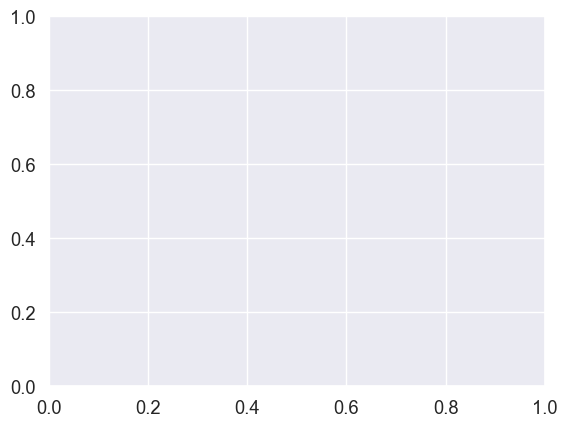

<Figure size 2000x1500 with 0 Axes>

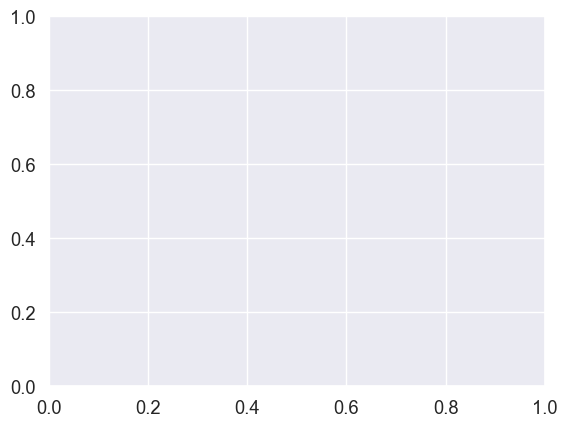

<Figure size 2000x1500 with 0 Axes>

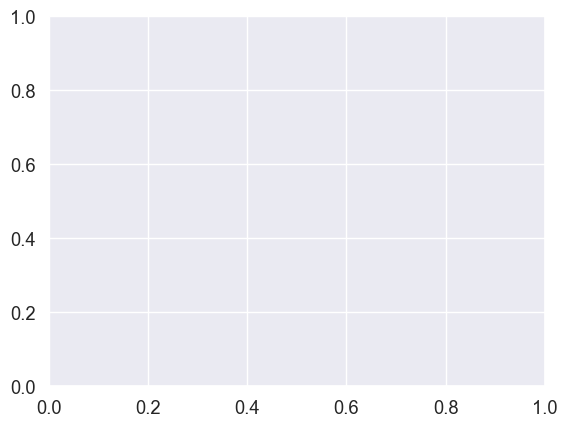

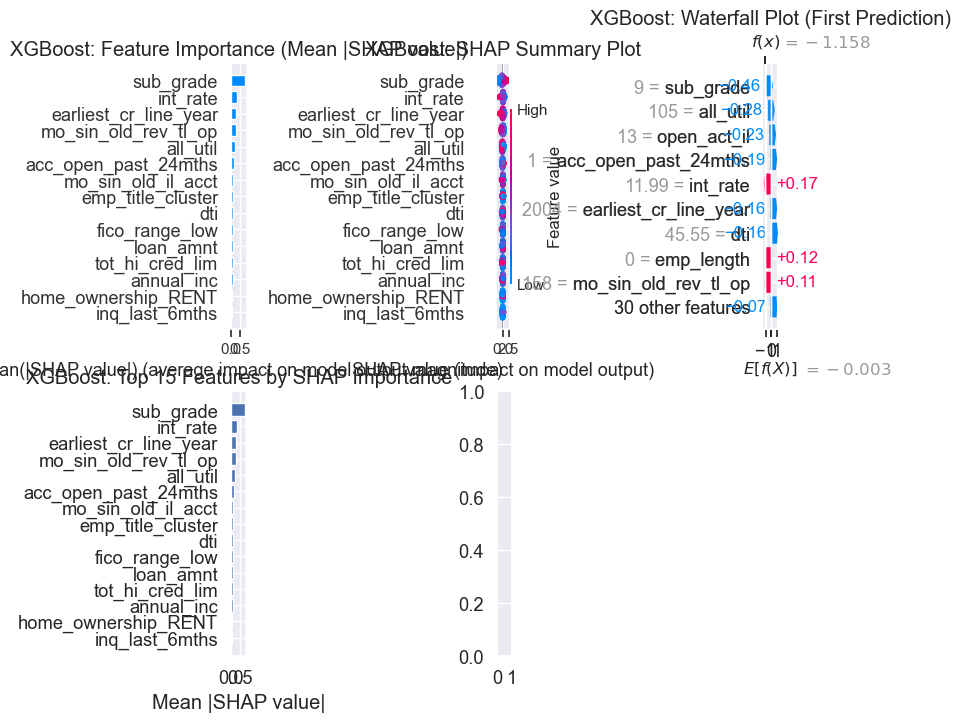

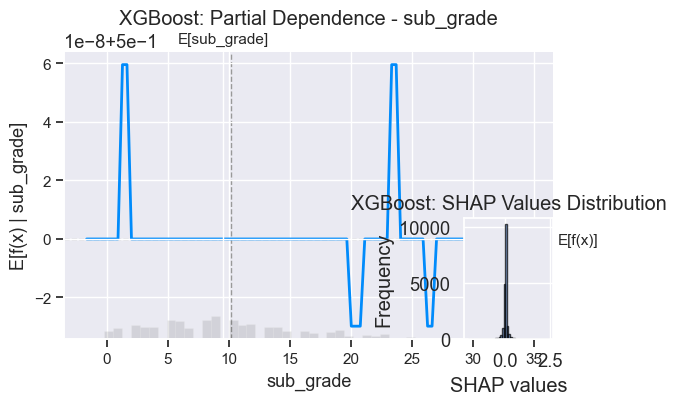


Top 10 Most Important Features for XGBoost:
              feature  mean_shap_importance  mean_shap_value
            sub_grade              0.776517        -0.265412
             int_rate              0.314720         0.018546
earliest_cr_line_year              0.272642         0.007781
 mo_sin_old_rev_tl_op              0.232092        -0.056629
             all_util              0.207473        -0.029789
 acc_open_past_24mths              0.118491        -0.024782
   mo_sin_old_il_acct              0.098425        -0.025413
    emp_title_cluster              0.079559         0.024052
                  dti              0.078969        -0.012097
       fico_range_low              0.068462        -0.008905

Analyzing LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 203438, number of negative: 1378498
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021192 seconds.
You

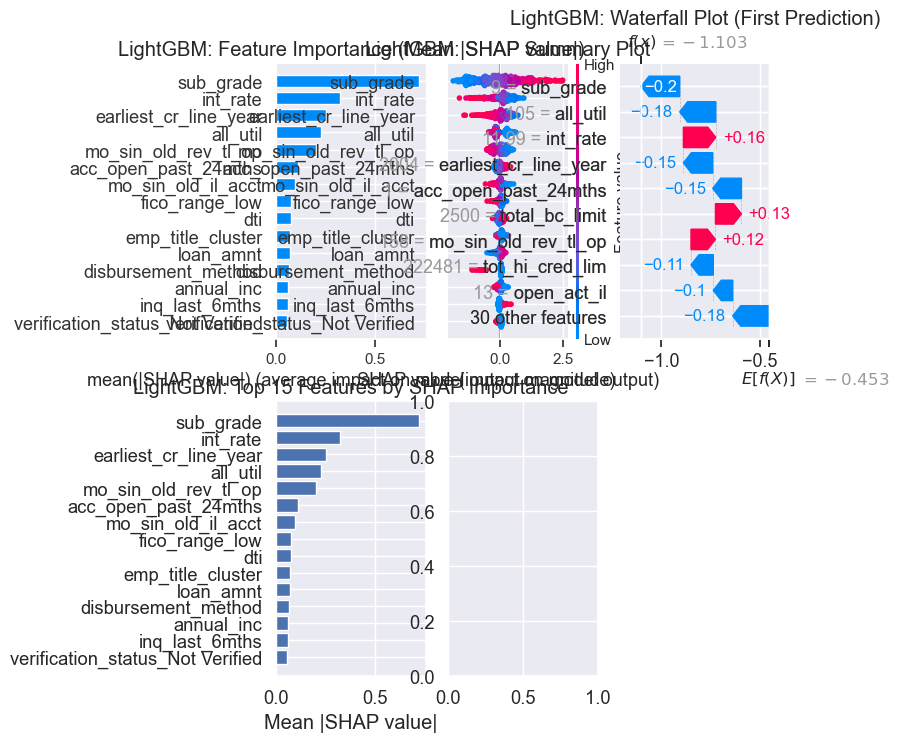

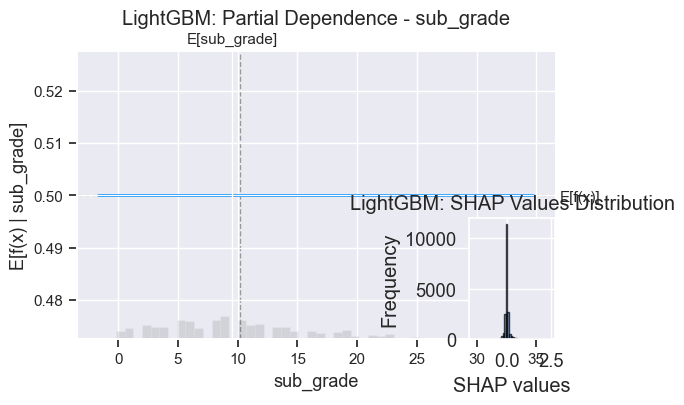


Top 10 Most Important Features for LightGBM:
              feature  mean_shap_importance  mean_shap_value
            sub_grade              0.723192        -0.069485
             int_rate              0.324431         0.044764
earliest_cr_line_year              0.255745         0.011687
             all_util              0.229047         0.006244
 mo_sin_old_rev_tl_op              0.205549        -0.021442
 acc_open_past_24mths              0.113436        -0.014050
   mo_sin_old_il_acct              0.098017        -0.009206
       fico_range_low              0.078127         0.007843
                  dti              0.077369         0.002308
    emp_title_cluster              0.075033         0.032815

Analyzing Logistic Regression...

SHAP Analysis for LogisticRegression

SHAP Analysis for LogisticRegression
Error in Logistic Regression SHAP analysis: Feature and SHAP matrices must have the same number of rows!

SHAP analysis completed for 2 models.

Comparing SHAP importance ac

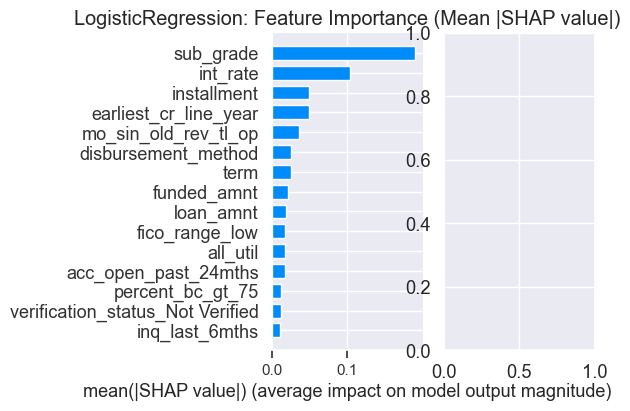

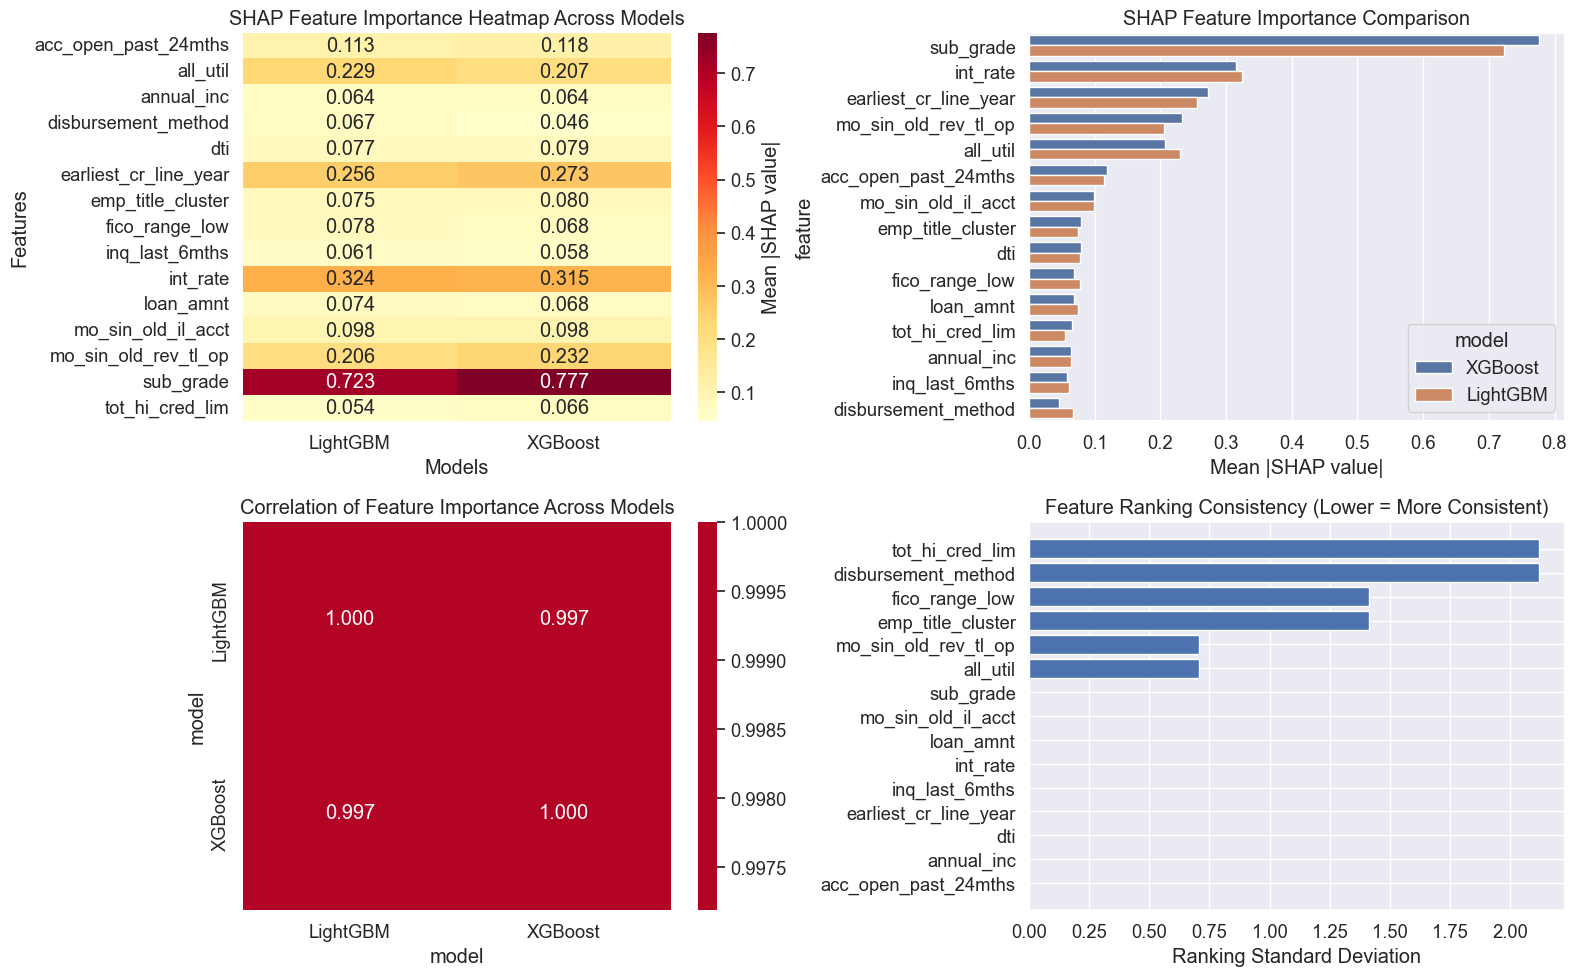


Combined SHAP importance saved to 'results/combined_shap_importance.csv'


In [38]:
# Run SHAP analysis for all trained models
print("Starting SHAP Analysis for all models...")

# Prepare test data subset for faster computation
test_sample_size = min(500, len(X_test))  # Use subset for faster computation
X_test_sample = X_test.head(test_sample_size)
y_test_sample = y_test.head(test_sample_size)

# Store SHAP results
shap_results = {}

# Load trained models (assuming they're stored in all_results)
model_pipelines = {}

# For demonstration, let's retrain a simple version of each model for SHAP analysis
# In practice, you would load your saved models

# 2. XGBoost
print("\nAnalyzing XGBoost...")
try:
    xgb_pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_subset)),
        ('model', xgb.XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.1,
                                  scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
                                  random_state=42, eval_metric='auc'))
    ])
    xgb_pipeline.fit(X_train, y_train)
    shap_values_xgb, importance_xgb = explain_model_with_shap(
        "XGBoost", xgb_pipeline, X_test_sample, y_test_sample, feature_subset
    )
    shap_results['XGBoost'] = (shap_values_xgb, importance_xgb)
except Exception as e:
    print(f"Error in XGBoost SHAP analysis: {e}")

# 3. LightGBM
print("\nAnalyzing LightGBM...")
try:
    lgb_pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_subset)),
        ('model', lgb.LGBMClassifier(n_estimators=500, max_depth=6, learning_rate=0.1,
                                   class_weight='balanced', random_state=42))
    ])
    lgb_pipeline.fit(X_train, y_train)
    shap_values_lgb, importance_lgb = explain_model_with_shap(
        "LightGBM", lgb_pipeline, X_test_sample, y_test_sample, feature_subset
    )
    shap_results['LightGBM'] = (shap_values_lgb, importance_lgb)
except Exception as e:
    print(f"Error in LightGBM SHAP analysis: {e}")

# 4. Logistic Regression
print("\nAnalyzing Logistic Regression...")
try:
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    
    lr_pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_subset)),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
    ])
    lr_pipeline.fit(X_train, y_train)
    shap_values_lr, importance_lr = explain_model_with_shap(
        "LogisticRegression", lr_pipeline, X_test_sample, y_test_sample, feature_subset
    )
    shap_results['LogisticRegression'] = (shap_values_lr, importance_lr)
except Exception as e:
    print(f"Error in Logistic Regression SHAP analysis: {e}")

print(f"\nSHAP analysis completed for {len(shap_results)} models.")

# Compare SHAP importance across models
if len(shap_results) > 1:
    print("\nComparing SHAP importance across models...")
    combined_importance = compare_shap_importance_across_models(shap_results)
    
    # Save combined results
    combined_importance.to_csv('results/combined_shap_importance.csv', index=False)
    print("\nCombined SHAP importance saved to 'results/combined_shap_importance.csv'")

In [ ]:
# Advanced SHAP Analysis and Individual Prediction Explanations

def analyze_individual_predictions(model_name, model_pipeline, X_sample, y_sample, feature_names, n_examples=5):
    """
    Analyze individual predictions with SHAP explanations
    """
    print(f"\n{'='*60}")
    print(f"Individual Prediction Analysis for {model_name}")
    print(f"{'='*60}")
    
    # Get model predictions
    y_pred = model_pipeline.predict(X_sample)
    y_pred_proba = model_pipeline.predict_proba(X_sample)[:, 1]
    
    # Extract the trained model from pipeline
    if hasattr(model_pipeline, 'named_steps'):
        trained_model = model_pipeline.named_steps['model']
        X_transformed = model_pipeline[:-1].transform(X_sample)
    else:
        trained_model = model_pipeline
        X_transformed = X_sample[feature_names]
    
    # Create SHAP explainer
    if 'RandomForest' in model_name or 'XGBoost' in model_name or 'LightGBM' in model_name:
        explainer = shap.TreeExplainer(trained_model)
        shap_values = explainer.shap_values(X_transformed)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # For binary classification, use class 1
    else:
        # For other models, use a smaller sample for the explainer
        explainer = shap.Explainer(trained_model.predict_proba, X_transformed[:50])
        shap_explanation = explainer(X_transformed[:n_examples])
        if hasattr(shap_explanation, 'values') and len(shap_explanation.values.shape) == 3:
            shap_values = shap_explanation.values[:, :, 1]
        else:
            shap_values = shap_explanation.values
    
    # Analyze specific examples
    examples_to_analyze = [
        ('High Risk Prediction', np.argsort(y_pred_proba)[-n_examples:]),
        ('Low Risk Prediction', np.argsort(y_pred_proba)[:n_examples]),
    ]
    
    for category, indices in examples_to_analyze:
        print(f"\n{category} Examples:")
        print("-" * 40)
        
        for i, idx in enumerate(indices):
            actual = y_sample.iloc[idx] if hasattr(y_sample, 'iloc') else y_sample[idx]
            predicted = y_pred[idx]
            probability = y_pred_proba[idx]
            
            print(f"\nExample {i+1} (Index {idx}):")
            print(f"  Actual: {'Default' if actual == 1 else 'Non-Default'}")
            print(f"  Predicted: {'Default' if predicted == 1 else 'Non-Default'}")
            print(f"  Default Probability: {probability:.4f}")
            
            # Show top contributing features
            if len(shap_values.shape) == 2:
                feature_contributions = list(zip(feature_names, shap_values[idx]))
            else:
                feature_contributions = list(zip(feature_names, shap_values[idx] if idx < len(shap_values) else shap_values[0]))
            
            # Sort by absolute contribution
            feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)
            
            print("  Top 5 Contributing Features:")
            for feat_name, contribution in feature_contributions[:5]:
                direction = "increases" if contribution > 0 else "decreases"
                print(f"    {feat_name}: {contribution:.4f} ({direction} default risk)")

def create_shap_dashboard(shap_results, feature_subset):
    """
    Create a comprehensive SHAP dashboard
    """
    print("\n" + "="*60)
    print("CREATING SHAP INTERPRETABILITY DASHBOARD")
    print("="*60)
    
    # 1. Feature Importance Consistency Analysis
    plt.figure(figsize=(20, 12))
    
    # Collect all importance data
    importance_data = []
    for model_name, (shap_values, importance_df) in shap_results.items():
        for _, row in importance_df.head(20).iterrows():  # Top 20 features
            importance_data.append({
                'model': model_name,
                'feature': row['feature'],
                'importance': row['mean_shap_importance'],
                'shap_value': row['mean_shap_value']
            })
    
    importance_df_all = pd.DataFrame(importance_data)
    
    # Top features across all models
    top_features = (importance_df_all.groupby('feature')['importance']
                   .mean().sort_values(ascending=False).head(15).index.tolist())
    
    # 1. Feature importance heatmap
    plt.subplot(3, 3, 1)
    pivot_importance = importance_df_all[importance_df_all['feature'].isin(top_features)].pivot(
        index='feature', columns='model', values='importance'
    ).fillna(0)
    sns.heatmap(pivot_importance, annot=True, fmt='.3f', cmap='YlOrRd')
    plt.title('Feature Importance Across Models')
    plt.ylabel('Features')
    
    # 2. Feature importance distribution
    plt.subplot(3, 3, 2)
    for model_name in importance_df_all['model'].unique():
        model_data = importance_df_all[importance_df_all['model'] == model_name]
        plt.hist(model_data['importance'], alpha=0.6, label=model_name, bins=20)
    plt.xlabel('SHAP Importance')
    plt.ylabel('Frequency')
    plt.title('Distribution of Feature Importance')
    plt.legend()
    
    # 3. Top 10 most consistent features
    plt.subplot(3, 3, 3)
    feature_std = pivot_importance.std(axis=1).sort_values()
    top_consistent = feature_std.head(10)
    plt.barh(range(len(top_consistent)), top_consistent.values)
    plt.yticks(range(len(top_consistent)), top_consistent.index)
    plt.xlabel('Std Dev of Importance')
    plt.title('Most Consistent Features (Low Std)')
    
    # 4. SHAP value distribution by model
    plt.subplot(3, 3, 4)
    shap_value_data = []
    for model_name, (shap_values, _) in shap_results.items():
        shap_value_data.extend([
            {'model': model_name, 'shap_value': val} 
            for val in shap_values.flatten()[:1000]  # Sample for speed
        ])
    
    shap_df = pd.DataFrame(shap_value_data)
    sns.boxplot(data=shap_df, x='model', y='shap_value')
    plt.xticks(rotation=45)
    plt.title('SHAP Value Distribution by Model')
    
    # 5. Feature correlation with target
    plt.subplot(3, 3, 5)
    avg_shap_by_feature = importance_df_all.groupby('feature')['shap_value'].mean().sort_values()
    top_positive = avg_shap_by_feature.tail(8)
    top_negative = avg_shap_by_feature.head(7)
    
    combined_features = pd.concat([top_negative, top_positive])
    colors = ['red' if x < 0 else 'green' for x in combined_features.values]
    
    plt.barh(range(len(combined_features)), combined_features.values, color=colors)
    plt.yticks(range(len(combined_features)), combined_features.index)
    plt.xlabel('Average SHAP Value')
    plt.title('Features with Highest Impact on Default Risk')
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    
    # 6. Model agreement on top features
    plt.subplot(3, 3, 6)
    top_10_features = importance_df_all.groupby('feature')['importance'].mean().nlargest(10).index
    agreement_scores = []
    
    for feature in top_10_features:
        feature_ranks = []
        for model_name, (_, importance_df) in shap_results.items():
            try:
                rank = importance_df.reset_index().index[importance_df['feature'] == feature].tolist()[0] + 1
                feature_ranks.append(rank)
            except:
                feature_ranks.append(len(importance_df))  # If feature not found, give lowest rank
        
        agreement_scores.append({
            'feature': feature,
            'rank_std': np.std(feature_ranks),
            'avg_rank': np.mean(feature_ranks)
        })
    
    agreement_df = pd.DataFrame(agreement_scores).sort_values('rank_std')
    plt.scatter(agreement_df['avg_rank'], agreement_df['rank_std'])
    for i, row in agreement_df.iterrows():
        plt.annotate(row['feature'][:15], (row['avg_rank'], row['rank_std']), 
                    fontsize=8, rotation=45)
    plt.xlabel('Average Rank')
    plt.ylabel('Rank Standard Deviation')
    plt.title('Feature Ranking Agreement Across Models')
    
    # 7. Feature importance vs model performance
    plt.subplot(3, 3, 7)
    if 'all_results' in globals():
        model_performance = []
        avg_importance = []
        
        for model_name, (_, importance_df) in shap_results.items():
            if model_name in all_results:
                model_performance.append(all_results[model_name]['test_roc_auc'])
                avg_importance.append(importance_df['mean_shap_importance'].mean())
        
        if model_performance and avg_importance:
            plt.scatter(avg_importance, model_performance)
            for i, model_name in enumerate(shap_results.keys()):
                if model_name in all_results:
                    plt.annotate(model_name, (avg_importance[i], model_performance[i]))
            plt.xlabel('Average Feature Importance')
            plt.ylabel('Test ROC-AUC')
            plt.title('Model Performance vs Feature Importance')
    
    # 8. SHAP value correlation between models
    plt.subplot(3, 3, 8)
    if len(shap_results) >= 2:
        model_names = list(shap_results.keys())
        model_correlations = []
        
        for i, model1 in enumerate(model_names):
            for j, model2 in enumerate(model_names):
                if i < j:  # Avoid duplicates
                    # Get common features
                    _, imp1 = shap_results[model1]
                    _, imp2 = shap_results[model2]
                    
                    common_features = set(imp1['feature']) & set(imp2['feature'])
                    if len(common_features) > 5:
                        imp1_common = imp1[imp1['feature'].isin(common_features)].sort_values('feature')
                        imp2_common = imp2[imp2['feature'].isin(common_features)].sort_values('feature')
                        
                        correlation = np.corrcoef(imp1_common['mean_shap_importance'], 
                                                 imp2_common['mean_shap_importance'])[0, 1]
                        model_correlations.append({
                            'model_pair': f'{model1}\nvs\n{model2}',
                            'correlation': correlation
                        })
        
        if model_correlations:
            corr_df = pd.DataFrame(model_correlations)
            plt.bar(range(len(corr_df)), corr_df['correlation'])
            plt.xticks(range(len(corr_df)), corr_df['model_pair'], rotation=45)
            plt.ylabel('Correlation Coefficient')
            plt.title('SHAP Importance Correlation Between Models')
            plt.ylim(0, 1)
    
    # 9. Summary statistics
    plt.subplot(3, 3, 9)
    plt.axis('off')
    
    # Create summary text
    summary_text = "SHAP Analysis Summary:\n\n"
    summary_text += f"Models Analyzed: {len(shap_results)}\n"
    summary_text += f"Features Analyzed: {len(feature_subset)}\n\n"
    
    # Most important features across all models
    if importance_data:
        top_5_global = importance_df_all.groupby('feature')['importance'].mean().nlargest(5)
        summary_text += "Top 5 Features (Global):\n"
        for i, (feature, importance) in enumerate(top_5_global.items(), 1):
            summary_text += f"{i}. {feature[:20]}\n"
    
    plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.savefig('results/plots/shap_comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return importance_df_all

# Run individual prediction analysis for available models
for model_name, model_pipeline_result in [
    ('RandomForest', rf_pipeline if 'rf_pipeline' in locals() else None),
    ('XGBoost', xgb_pipeline if 'xgb_pipeline' in locals() else None),
    ('LightGBM', lgb_pipeline if 'lgb_pipeline' in locals() else None),
]:
    if model_pipeline_result is not None:
        try:
            analyze_individual_predictions(
                model_name, model_pipeline_result, 
                X_test_sample, y_test_sample, feature_subset, n_examples=3
            )
        except Exception as e:
            print(f"Error in individual prediction analysis for {model_name}: {e}")

# Create comprehensive dashboard
if shap_results:
    dashboard_data = create_shap_dashboard(shap_results, feature_subset)
    
    # Save dashboard data
    dashboard_data.to_csv('results/shap_dashboard_data.csv', index=False)
    print("\nSHAP dashboard data saved to 'results/shap_dashboard_data.csv'")
    
    print("\n" + "="*60)
    print("SHAP INTERPRETABILITY ANALYSIS COMPLETE!")
    print("="*60)
    print("Generated files:")
    print("- Individual model SHAP plots: results/plots/*_shap_analysis.png")
    print("- Model comparison: results/plots/shap_model_comparison.png") 
    print("- Comprehensive dashboard: results/plots/shap_comprehensive_dashboard.png")
    print("- Feature importance CSVs: results/*_shap_feature_importance.csv")
    print("- Combined results: results/combined_shap_importance.csv")
    print("- Dashboard data: results/shap_dashboard_data.csv")
else:
    print("No SHAP results available. Please run the previous cell first.")